## 1. Data Setup

In [22]:
import h5py
import numpy as np

with h5py.File('../training_data_3params_200.h5', 'r') as f:
    flux = f['flux'][:]
    params = f['parameters'][:]
    labels = f['labels'][:]

class_names = ['sw', 'msh', 'msp', 'ps', 'lobe']
class_to_idx = {'sw': 0, 'msh': 1, 'msp': 2, 'ps': 3, 'lobe':4}

PARAM_SIZE = params.shape[2]

import torch

X1_tensor = torch.log10(torch.from_numpy(flux).type(torch.float) + 1.0) # float is float32
X2_tensor = torch.from_numpy(params).type(torch.float) # float is float32
y_tensor = torch.from_numpy(labels).type(torch.LongTensor).squeeze()

nan_mask = torch.isnan(X2_tensor)
num_nan = torch.sum(nan_mask).item()
print("Number of NaNs:", num_nan)

# Replace NaN values with 0
X2_tensor = torch.nan_to_num(X2_tensor, nan=0.0)

# change to color, height, width, torch format
X1_tensor = torch.permute(X1_tensor, (0, 2, 1))
X1_tensor.size()

X2_tensor = torch.permute(X2_tensor, (0, 2, 1))

from sklearn.model_selection import train_test_split

# Split indices for training and testing
train_indices, test_indices = train_test_split(range(len(X1_tensor)), test_size=0.2, stratify=y_tensor, random_state=42)

# Use indices to split the datasets
X1_train, X1_val = X1_tensor[train_indices], X1_tensor[test_indices]
X2_train, X2_val = X2_tensor[train_indices], X2_tensor[test_indices]
y_train, y_val = y_tensor[train_indices], y_tensor[test_indices]

X1_tensor.shape, X2_tensor.shape, y_tensor.shape


Number of NaNs: 0


(torch.Size([1000, 32, 40]), torch.Size([1000, 3, 40]), torch.Size([1000]))

In [23]:
PARAM_SIZE

3

In [24]:
min_vals_X1 = X1_train.min()
max_vals_X1 = X1_train.max()

min_vals_X2 = torch.zeros(PARAM_SIZE)
max_vals_X2 = torch.zeros(PARAM_SIZE)
for i in range(0,PARAM_SIZE):
    min_vals_X2[i] = X2_train[:,i,:].min()
    max_vals_X2[i] = X2_train[:,i,:].max()

min_vals_X1, max_vals_X1, min_vals_X2, max_vals_X2

(tensor(0.),
 tensor(8.0543),
 tensor([  0.3847,  45.2129, -24.1444]),
 tensor([   85.2243, 10612.0547,    12.7759]))

In [25]:
def min_max_scaling(tensor, min_val, max_val, feature_range=(0, 1)):
  """
  Scales a tensor to a specified range using min-max scaling.

  Args:
    tensor (torch.Tensor): The input tensor.
    feature_range (tuple, optional): The desired range for the scaled tensor. Defaults to (0, 1).

  Returns:
    torch.Tensor: The scaled tensor.
  """
  min_val = min_val #tensor.min()
  max_val = max_val #tensor.max()
  scaled_tensor = (tensor - min_val) / (max_val - min_val)

  #Adjust to the desired range
  scaled_tensor = scaled_tensor * (feature_range[1] - feature_range[0]) + feature_range[0]
  return scaled_tensor

def normalize_preserve_zero(tensor, min_val=None, max_val=None):
    """
    Normalize tensor to [-1, 1] while keeping zero at zero
    Uses piecewise linear transformation based on min/max values
    
    Args:
        tensor: Input tensor
        min_val: Minimum value (computed if None)
        max_val: Maximum value (computed if None)
    
    Returns:
        normalized tensor, min_val, max_val
    """
    if min_val is None:
        min_val = torch.min(tensor)
    if max_val is None:
        max_val = torch.max(tensor)
    
    # Get the absolute values of min and max for scaling
    abs_min = torch.abs(min_val)
    abs_max = torch.abs(max_val)
    
    # Initialize normalized tensor
    normalized = torch.zeros_like(tensor)
    
    # For negative values: map [min_val, 0] to [-1, 0]
    negative_mask = tensor < 0
    normalized[negative_mask] = tensor[negative_mask] / abs_min
    
    # For positive values: map [0, max_val] to [0, 1]
    positive_mask = tensor >= 0
    normalized[positive_mask] = tensor[positive_mask] / abs_max
    
    return normalized



min_vals_X1 = X1_train.min() #-X1_train.max()
max_vals_X1 = X1_train.max()
X1_train = min_max_scaling(X1_train, min_vals_X1, max_vals_X1, feature_range=(0, 1))
X1_val = (X1_test - min_vals_X1) / (max_vals_X1 - min_vals_X1)

min_vals_X2 = torch.zeros(PARAM_SIZE)
max_vals_X2 = torch.zeros(PARAM_SIZE)

for i in range(0,PARAM_SIZE-1):
    min_vals_X2[i] = X2_train[:,i,:].min()
    max_vals_X2[i] = X2_train[:,i,:].max()
    X2_train[:,i,:] = min_max_scaling(X2_train[:,i,:], min_vals_X2[i], max_vals_X2[i], feature_range=(0, 1))
    X2_val[:,i,:] = (X2_val[:,i,:] - min_vals_X2[i]) / (max_vals_X2[i] - min_vals_X2[i]) #(0,1)

x_ind = 2
min_vals_X2[x_ind] = X2_train[:,x_ind,:].min()
max_vals_X2[x_ind] = X2_train[:,x_ind,:].max()

X2_train[:,x_ind,:] = normalize_preserve_zero(X2_train[:,x_ind,:], min_vals_X2[x_ind],max_vals_X2[x_ind])
X2_val[:,x_ind,:] = normalize_preserve_zero(X2_val[:,x_ind,:], min_vals_X2[x_ind],max_vals_X2[x_ind])

print(X2_val[:,x_ind,:].min())
print(X2_val[:,x_ind,:].max())

X1_train = X1_train.unsqueeze(dim=1)
X1_val = X1_test.unsqueeze(dim=1)

tensor(-0.9988)
tensor(0.9999)


In [20]:
# # Test that zero stays zero
# zero_tensor = torch.tensor([0.0])
# zero_normalized= normalize_preserve_zero(zero_tensor, min_vals_X2[2],max_vals_X2[2])
# zero_normalized

In [27]:
X1_train.shape, X1_val.shape, X2_train.shape, X2_val.shape, y_train.shape, y_val.shape

(torch.Size([800, 1, 32, 40]),
 torch.Size([200, 1, 1, 32, 40]),
 torch.Size([800, 3, 40]),
 torch.Size([200, 3, 40]),
 torch.Size([800]),
 torch.Size([200]))

In [28]:
X1_train.min(), X1_train.max()

(tensor(0.), tensor(1.))

## 2. Model

In [57]:
import torch
from torch import nn

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Shape: (num_samples, num_channels, sequence_length)

X2_train_avg = np.array(X2_train.mean(axis=2))   
X2_val_avg = np.array(X2_val.mean(axis=2))     

#option 1: n_estimators=20, random_state=42, max_depth=4 97%
#option 2: n_estimators=20, random_state=42, max_depth=3 97%
#option 3: n_estimators=30, random_state=42, max_depth=4 99% 
# max_depth is 3 or 4 for best results.

# Train RF
rf = RandomForestClassifier(n_estimators=30, random_state=42, max_depth=4)
rf.fit(X2_train_avg, np.array(y_train))

# Evaluate
y_pred = rf.predict(X2_val_avg)
print(classification_report(np.array(y_val), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      0.97      0.99        40
           3       0.98      1.00      0.99        40
           4       1.00      1.00      1.00        40

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [58]:
rf.predict_proba(X2_val_avg).shape

(200, 5)

## 3. Training 

In [59]:
from tqdm.auto import tqdm



# #prediction from random forest
rf_output = rf.predict_proba(X2_val_avg) # shape: (119, 6)
# rf_output
# print(rf_output)

# Fuse probablities (e.g., by averaging)

combined_output= rf_output
y_pred_numpy = np.argmax(combined_output, axis=1)

y_pred_tensor = torch.Tensor(y_pred_numpy)
y_pred_tensor

tensor([2., 0., 1., 1., 3., 0., 2., 3., 2., 4., 0., 2., 0., 3., 0., 3., 1., 4.,
        1., 0., 4., 3., 4., 4., 0., 2., 1., 1., 3., 0., 1., 2., 0., 3., 0., 3.,
        2., 1., 0., 0., 2., 1., 0., 3., 1., 1., 4., 2., 3., 1., 0., 3., 3., 2.,
        0., 2., 3., 4., 2., 2., 2., 3., 4., 3., 4., 4., 2., 1., 2., 3., 1., 0.,
        3., 4., 3., 4., 2., 0., 3., 2., 2., 1., 3., 3., 4., 1., 4., 4., 4., 3.,
        1., 4., 4., 2., 2., 3., 4., 3., 1., 1., 2., 2., 1., 4., 4., 3., 0., 4.,
        4., 3., 4., 4., 1., 1., 3., 1., 0., 0., 0., 1., 0., 1., 0., 4., 4., 3.,
        1., 3., 0., 4., 0., 2., 3., 1., 3., 2., 4., 2., 4., 1., 1., 1., 1., 4.,
        2., 0., 1., 0., 1., 2., 2., 0., 0., 2., 3., 0., 0., 0., 4., 0., 3., 2.,
        0., 0., 4., 4., 1., 1., 2., 2., 4., 4., 4., 1., 3., 0., 3., 2., 0., 4.,
        3., 0., 3., 2., 1., 1., 3., 2., 4., 2., 4., 0., 3., 3., 1., 2., 1., 2.,
        0., 3.])

In [60]:
print(classification_report(y_val, y_pred_tensor))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      0.97      0.99        40
           3       0.98      1.00      0.99        40
           4       1.00      1.00      1.00        40

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



## 4. Save the model

In [61]:
with h5py.File('../test_data_3params.h5', 'r') as f:
    flux = f['flux'][:]
    params = f['parameters'][:]
    labels = f['labels'][:]

class_names = ['sw', 'msh', 'msp', 'ps', 'lobe']
class_to_idx = {'sw': 0, 'msh': 1, 'msp': 2, 'ps': 3, 'lobe':4}

PARAM_SIZE = params.shape[2]

import torch

X1_tensor_test = torch.log10(torch.from_numpy(flux).type(torch.float)+1.0) # float is float32
X2_tensor_test = torch.from_numpy(params).type(torch.float) # float is float32
y_tensor_test = torch.from_numpy(labels).type(torch.LongTensor).squeeze()

nan_mask = torch.isnan(X2_tensor_test)
num_nan = torch.sum(nan_mask).item()
# print("Number of NaNs:", num_nan)

# Replace NaN values with 0
X2_tensor_test = torch.nan_to_num(X2_tensor_test, nan=0.0)

# # 200 sample model 3 params
# normalization to training data values
min_vals_X1 = torch.tensor(0.)
max_vals_X1 = torch.tensor(8.0543)
min_vals_X2 = torch.tensor([0.3847, 45.2129, -24.1444])
max_vals_X2 = torch.tensor([85.2243, 10612.0547,    12.7759])

PARAM_SIZE = 3
    
X1_tensor_test = (X1_tensor_test - min_vals_X1) / ( max_vals_X1 - min_vals_X1)
print('X1 shape : ', X1_tensor_test.shape)
   
    
for i in range(0,PARAM_SIZE-1):
    X2_tensor_test[:,:,i] = (X2_tensor_test[:,:,i] - min_vals_X2[i]) / ( max_vals_X2[i] - min_vals_X2[i])

X2_tensor_test[:,:,2] = normalize_preserve_zero(X2_tensor_test[:,:,2], min_vals_X2[2],max_vals_X2[2])
print('x2 shape : ', X2_tensor_test.shape)
    
# change to color, height, width, torch format
X1_tensor_test = torch.permute(X1_tensor_test, (0, 2, 1))
print('X1 shape after permute: ', X1_tensor_test.shape)

X2_tensor_test = torch.permute(X2_tensor_test, (0, 2, 1))
print('X2 shape after permute: ', X2_tensor_test.shape)
X2_test_avg = np.array(X2_tensor_test.mean(axis=2))     # shape becomes (length, 3)
print('X2 shape after mean: ', X2_test_avg.shape)
    
X1_tensor_test = X1_tensor_test.unsqueeze(dim=1)
    
# Make predictions with trained model
from tqdm.auto import tqdm




# #prediction from random forest
rf_output = rf.predict_proba(X2_test_avg) 

# # Fuse probablities (e.g., by averaging)

combined_output= (rf_output)
y_pred_numpy = np.argmax(combined_output, axis=1)

y_pred_tensor = torch.Tensor(y_pred_numpy)


X1 shape :  torch.Size([500, 40, 32])
x2 shape :  torch.Size([500, 40, 3])
X1 shape after permute:  torch.Size([500, 32, 40])
X2 shape after permute:  torch.Size([500, 3, 40])
X2 shape after mean:  (500, 3)


mlxtend version: 0.23.3


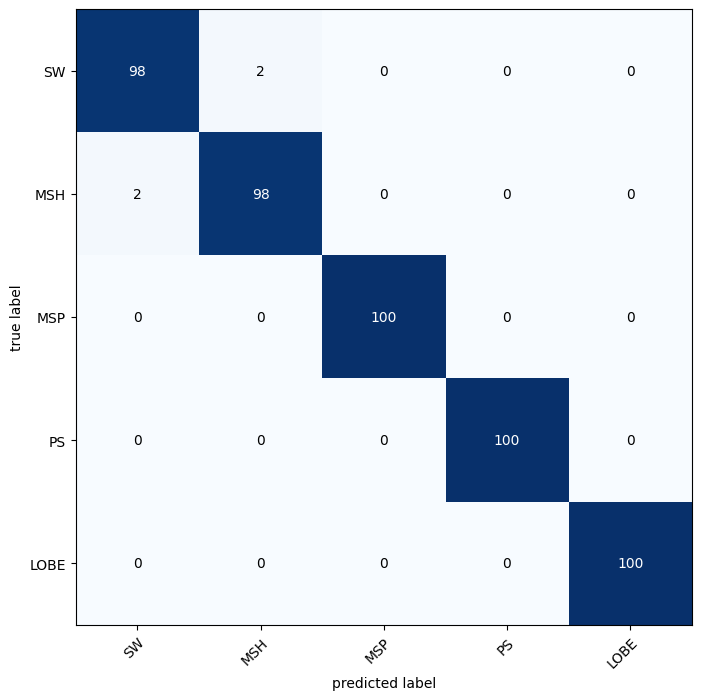

In [62]:
y = torch.Tensor(np.argmax(rf_output, axis=1))

import matplotlib.pyplot as plt
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
class_names = ['SW', 'MSH', 'MSP', 'PS', 'LOBE']

# setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes=5, task='multiclass')
confmat_tensor = confmat(preds=y,
                         target=y_tensor_test)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(8,8));

# fig.savefig('ConfMatrix.png', dpi=fig.dpi)
plt.show()

In [63]:
print(classification_report(y_tensor_test, y_pred_tensor, target_names = class_names))

              precision    recall  f1-score   support

          SW       0.98      0.98      0.98       100
         MSH       0.98      0.98      0.98       100
         MSP       1.00      1.00      1.00       100
          PS       1.00      1.00      1.00       100
        LOBE       1.00      1.00      1.00       100

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



In [64]:
from colab_utils import FluxCNNModel
import torch
# Instantiate a fresh instance of multiinputmodel
loaded_CNN = FluxCNNModel()
# RFModel = rf()



# Load model state dict
loaded_CNN.load_state_dict(torch.load(f="./model_cnn.pth"))

print(f"Loaded model:\n{FluxCNNModel}")

cnn_model = loaded_CNN

Loaded model:
<class 'colab_utils.FluxCNNModel'>


In [66]:
import os
import torch
from torch import nn
# path for data 
os.environ["SPEDAS_DATA_DIR"] = "/Volumes/datadir/mmsdata"  #"/Users/naah5403/data"

import pyspedas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import more_itertools
import xarray as xr
from pytplot import tplot, del_data, options, get_data, get, store_data, ylim, tplot_options, tlimit
from pyspedas import tinterpol, time_string

def predictions_cnn_rf(cnn_model, rf_model, trange):

    tname = trange[0].replace('/','_').replace('-','').replace(':','')
    probe = '1'
    pyspedas.mms.fgm(trange=trange, data_rate='srvy', probe=probe)
    pyspedas.mms.fpi(trange=trange,center_measurement=True, data_rate='fast',datatype=['dis-moms'], probe=probe)
    pyspedas.mms.mec(trange=trange, data_rate='srvy', probe=probe)
    
    BgseN ='mms1_fgm_b_gse_srvy_l2'
    DeniN = 'mms1_dis_numberdensity_fast'
    ViN = 'mms1_dis_bulkv_gse_fast'
    TiperpN = 'mms1_dis_tempperp_fast'
    TiparaN = 'mms1_dis_temppara_fast'
    posN = 'mms1_mec_r_gse'
    
    omni_flux = get_data('mms1_dis_energyspectr_omni_fast')
    energy = get_data('mms1_dis_energy_fast')
    
    # Interpol to ion fpi time 30ms
    tinterpol(BgseN, DeniN)
    tinterpol(posN, DeniN)
    
    #times, Bgse = get_data(BgseN+'-itrp')
    
    ni = get_data(DeniN)
    B = get_data(BgseN+'-itrp')
    Vi = get_data(ViN)
    Tiperp = get_data(TiperpN)
    Tipara = get_data(TiparaN)
    pos = get_data(posN+'-itrp')
    
    df_time = time_string(ni.times)
    df_ni = pd.DataFrame(ni.y, columns = ['ni'],index = [df_time])
    df_B = pd.DataFrame(B.y, columns = ['Bx','By','Bz','Btot'],index = [df_time])
    df_Vi = pd.DataFrame(Vi.y, columns = ['Vx','Vy','Vz'],index = [df_time])
    df_Vitot = pd.DataFrame(np.linalg.norm(df_Vi.values, axis=1), columns = ['vitot'], index = [df_time])
    df_Tiperp = pd.DataFrame(Tiperp.y, columns = ['Tiperp'],index = [df_time])
    df_Tipara = pd.DataFrame(Tipara.y, columns = ['Tipara'],index = [df_time])
    df_Ti = pd.concat([df_Tiperp,df_Tipara], axis=1)
    df_Titot = df_Ti.mean(axis=1)
    df_pos = pd.DataFrame(pos.y/6378., columns = ['X','Y','Z'],index = [df_time])
    
    df_final = pd.concat([df_B, df_ni, df_Vi, df_Vitot, df_Ti, df_Titot, df_pos], axis=1)
    df_final.columns = ['bx', 'by', 'bz', 'btot', 'ni', 'vix', 'viy', 'viz', 'vitot', 'Tiperp', 'Tipara', 'Titot', 'X', 'Y', 'Z']
    
    
    
    block_size = 40
    blocks = list(more_itertools.chunked(df_final.values, block_size))
    blocks = [np.array(x) for x in blocks]
    
    x_input_all = np.array(blocks[:-1])
    
    timestamps = list(more_itertools.chunked(df_final.index, block_size))
    timestamps = np.array(timestamps[:-1])
    
    index = pd.DatetimeIndex(timestamps[:,0,0])
    
    block_size = 40
    blocks = list(more_itertools.chunked(omni_flux.y, block_size))
    blocks = [np.array(x) for x in blocks]
    
    x_input_flux = np.array(blocks[:-1])
    
    
    X1 = x_input_flux
    
    X2_1 = x_input_all[:,:,3]  # btot
    X2_1 = np.expand_dims(X2_1, axis=2)
    X2_2 = x_input_all[:,:,11:13]  # T_tot, X
    
    X2 = np.concatenate((X2_1, X2_2), axis=2)
    
    import torch
    X1_tensor_test = torch.log10(torch.from_numpy(np.array(X1)).type(torch.float)+1.0) # float is float32
    X2_tensor_test = torch.from_numpy(np.array(X2)).type(torch.float) # float is float32
    
    nan_mask = torch.isnan(X2_tensor_test)
    num_nan = torch.sum(nan_mask).item()
    print("Number of NaNs:", num_nan)
    
    # Replace NaN values with 0
    X2_tensor_test = torch.nan_to_num(X2_tensor_test, nan=0.0)
    
    # normalization to training data values
    min_vals_X1 = torch.tensor(0.)
    max_vals_X1 = torch.tensor(8.0543)
    min_vals_X2 = torch.tensor([0.3847, 45.2129, -24.1444])
    max_vals_X2 = torch.tensor([85.2243, 10612.0547,    12.7759])

    PARAM_SIZE = 3
    
    X1_tensor_test = (X1_tensor_test - min_vals_X1) / ( max_vals_X1 - min_vals_X1)
    print('x1 shape : ', X1_tensor_test.shape)
          
    def normalize_preserve_zero(tensor, min_val=None, max_val=None):
        """
        Normalize tensor to [-1, 1] while keeping zero at zero
        Uses piecewise linear transformation based on min/max values
        
        Args:
            tensor: Input tensor
            min_val: Minimum value (computed if None)
            max_val: Maximum value (computed if None)
        
        Returns:
            normalized tensor, min_val, max_val
        """
        if min_val is None:
            min_val = torch.min(tensor)
        if max_val is None:
            max_val = torch.max(tensor)
        
        # Get the absolute values of min and max for scaling
        abs_min = torch.abs(min_val)
        abs_max = torch.abs(max_val)
        
        # Initialize normalized tensor
        normalized = torch.zeros_like(tensor)
        
        # For negative values: map [min_val, 0] to [-1, 0]
        negative_mask = tensor < 0
        normalized[negative_mask] = tensor[negative_mask] / abs_min
        
        # For positive values: map [0, max_val] to [0, 1]
        positive_mask = tensor >= 0
        normalized[positive_mask] = tensor[positive_mask] / abs_max
        
        return normalized
    print('x2 shape : ', X2_tensor_test.shape)
    
    for i in range(0,PARAM_SIZE-1):
        X2_tensor_test[:,:,i] = (X2_tensor_test[:,:,i] - min_vals_X2[i]) / ( max_vals_X2[i] - min_vals_X2[i])

    X2_tensor_test[:,:,2] = normalize_preserve_zero(X2_tensor_test[:,:,2], min_vals_X2[2],max_vals_X2[2])

    # change to color, height, width, torch format
    X1_tensor_test = torch.permute(X1_tensor_test, (0, 2, 1))
    print('X1 after permute: ', X1_tensor_test.shape)
    
    X2_tensor_test = torch.permute(X2_tensor_test, (0, 2, 1))
    print('X2 after permute: ', X2_tensor_test.shape)

    X2_test_avg = np.array(X2_tensor_test.mean(axis=2))     # shape becomes (length, 3)
    print('X2 avg : ', X2_test_avg.shape)
    
    X1_tensor_test = X1_tensor_test.unsqueeze(dim=1)
    print('X1 after unsqueeze: ', X1_tensor_test.shape)
    
    # Make predictions with trained model
    from tqdm.auto import tqdm	
    
    # Make predictions with trained CNN model and rf
    num_samples = len(X1_tensor_test)
    batch_size = 8
    
    y_pred_cnn = []
    cnn_model.eval()
    with torch.inference_mode():
        for i in tqdm(range(0, num_samples, batch_size)):
            batch_X1 = X1_tensor_test[i:i+batch_size]
            
            y_logit = cnn_model(batch_X1)
            y_cnn = torch.softmax(y_logit, dim=1)
            # print(y_cnn)
            y_pred_cnn.append(y_cnn)


    # # prediction from cnn model
    y_pred_cnn_tensor = torch.cat(y_pred_cnn)

    # prediction from random forest
    rf_output = rf_model.predict_proba(X2_test_avg)
    # prediction from cnn only
    y_cnn = np.argmax(y_pred_cnn_tensor.numpy(), axis=1)

    y_cnn = pd.DataFrame(y_cnn)    
    y_cnn = y_cnn.set_index(index)


    # prediction from rf only
    y_rf = np.argmax(rf_output, axis=1)
    y_rf = pd.DataFrame(y_rf)    
    y_rf = y_rf.set_index(index)

    # Fuse probablities (e.g., by averaging)
    
    combined_output= (y_pred_cnn_tensor.numpy() + rf_output ) / 2
    y_pred_numpy = np.argmax(combined_output, axis=1)

    
    y_pred_tensor = torch.Tensor(y_pred_numpy)
    y_combined = y_pred_tensor
    y_combined = pd.DataFrame(y_combined)
    y_combined = y_combined.set_index(index)


    def replace_pair_values(tensor, pair_list, new_value):
        """
        pair_list: list of (a,b) pairs to consider (will treat (a,b) and (b,a) the same)
        new_value: scalar to set on both elements of each matched pair
        """
        # Build mask for pairs in y[:-1] vs y[1:]
        a = tensor[:-1]
        b = tensor[1:]
        # Start with all False
        mask_pairs = torch.zeros_like(a, dtype=torch.bool)
        for p in pair_list:
            p0, p1 = p
            mask_pairs |= ((a == p0) & (b == p1)) | ((a == p1) & (b == p0))
    
        # Expand to full-length mask marking both members of each matched pair
        mask_full = torch.zeros_like(tensor, dtype=torch.bool)
        mask_full[:-1] |= mask_pairs
        mask_full[1:]  |= mask_pairs
    
        tensor[mask_full] = new_value
        return tensor

    # Sequentially apply the same groups as your original code:
    # 1) (1<->2) -> 5  MSH <-> MSP  -> MP
    replace_pair_values(y_pred_tensor, [(1,2)], 5)
    
    # 2) (0<->1) -> 6  SW <-> MSH -> BS
    replace_pair_values(y_pred_tensor, [(0,1)], 6)
    
    # 3) (3<->4) -> 7 PS <-> LOBE -> PSBL
    replace_pair_values(y_pred_tensor, [(3,4)], 7)

    
    y_pred_tensor = pd.DataFrame(y_pred_tensor)
    y_pred_tensor = y_pred_tensor.set_index(index)
    
    B = pd.DataFrame(X2_test_avg[:,0])
    B = B.set_index(index)
    Ti = pd.DataFrame(X2_test_avg[:,1])
    Ti = Ti.set_index(index)
    X = pd.DataFrame(X2_test_avg[:,2])
    X = X.set_index(index)

    
    figure, axis = plt.subplots(5, 1,  figsize=(20, 12), sharex=True, constrained_layout=True) #sharex=True
    pcm=axis[0].pcolormesh(np.array(time_string(energy.times)).astype("datetime64[ns]"),energy.y[0],
                                   np.log10(np.transpose(omni_flux.y[:,:])),cmap='nipy_spectral',shading='auto')
    axis[0].set_yscale('log')
    axis[0].set_ylabel('Ion Spectrogram')
    figure.colorbar(pcm, ax=axis[0], label="$keV/(cm^2~s~sr~keV)$", pad=0)
    # pcm.set_clim(3,6)
    
    size=18
    plt.rc('font', size=size)          # controls default text sizes
    plt.rc('axes', titlesize=size)     # fontsize of the axes title
    plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=size+2)    # legend fontsize
    plt.rc('figure', titlesize=size)  # fontsize of the figure title
    
    axis[1].plot(index, B, 'ok', label='Magnetic Field')
    # axis[1].plot(index, Ni, 'og', label='Density')
    axis[1].plot(index, Ti, 'or', label='Temperature')
    axis[1].plot(index, X, 'ob', label='Position')
    axis[1].grid()
    axis[1].set_ylabel('Parameters')
    axis[1].legend()    
    

    axis[2].plot(index, y_rf, 'oc', label='RF')
    axis[2].plot(index, y_cnn, 'om', label='CNN')
    # axis[2].plot(index, y_pred_tensor, 'ok')
    # axis[2].yaxis.set_ticks(np.arange(0,9,1))
    # axis[2].yaxis.set_ticklabels(['SW', 'FS', 'MSH', 'MSP', 'PS', 'LOBE', 'MP', 'BS', 'PSBL'])
    axis[2].yaxis.set_ticks(np.arange(0,5,1))
    axis[2].yaxis.set_ticklabels(['SW', 'MSH', 'MSP', 'PS', 'LOBE'])
    axis[2].grid()
    axis[2].set_ylabel('RF and CNN')
    axis[2].legend()    
    
    axis[3].plot(index, y_combined, 'og', label='Combined model')
    # axis[2].plot(index, y_pred_tensor, 'ok')
    # axis[2].yaxis.set_ticks(np.arange(0,9,1))
    # axis[2].yaxis.set_ticklabels(['SW', 'FS', 'MSH', 'MSP', 'PS', 'LOBE', 'MP', 'BS', 'PSBL'])
    axis[3].yaxis.set_ticks(np.arange(0,5,1))
    axis[3].yaxis.set_ticklabels(['SW', 'MSH', 'MSP', 'PS', 'LOBE'])
    axis[3].grid()
    axis[3].set_ylabel('Combined')
    axis[3].legend() 
    
    axis[4].plot(index, y_pred_tensor, 'ok', label='Combined model with boundaries')
    axis[4].yaxis.set_ticks(np.arange(0,8,1))
    axis[4].yaxis.set_ticklabels(['SW', 'MSH', 'MSP', 'PS', 'LOBE', 'MP', 'BS', 'PSBL'])
    axis[4].grid()
    axis[4].set_ylabel('Predictions')
    axis[4].legend() 
    # axis[1].set_xlabel('time (UTC)')
    
    # plt.savefig("CNN_RF05_4_Case05_"+tname+".png")
    plt.show()


12-Jan-26 14:54:20: Downloading mms1_fgm_srvy_l2_20220718_v5.365.0.cdf to pydata/mms1/fgm/srvy/l2/2022/07
12-Jan-26 14:54:40: Downloading mms1_fpi_fast_l2_dis-moms_20220718060000_v3.4.0.cdf to pydata/mms1/fpi/fast/l2/dis-moms/2022/07
12-Jan-26 14:54:41: Downloading mms1_fpi_fast_l2_dis-moms_20220718080000_v3.4.0.cdf to pydata/mms1/fpi/fast/l2/dis-moms/2022/07
12-Jan-26 14:54:41: Downloading mms1_fpi_fast_l2_dis-moms_20220718100000_v3.4.0.cdf to pydata/mms1/fpi/fast/l2/dis-moms/2022/07
12-Jan-26 14:54:41: Downloading mms1_fpi_fast_l2_dis-moms_20220718120000_v3.4.0.cdf to pydata/mms1/fpi/fast/l2/dis-moms/2022/07
12-Jan-26 14:54:41: Downloading mms1_fpi_fast_l2_dis-moms_20220718140000_v3.4.0.cdf to pydata/mms1/fpi/fast/l2/dis-moms/2022/07
12-Jan-26 14:54:41: Downloading mms1_fpi_fast_l2_dis-moms_20220718160000_v3.4.0.cdf to pydata/mms1/fpi/fast/l2/dis-moms/2022/07
12-Jan-26 14:54:41: Downloading mms1_fpi_fast_l2_dis-moms_20220718180000_v3.4.0.cdf to pydata/mms1/fpi/fast/l2/dis-moms/2022/0

Number of NaNs: 0
x1 shape :  torch.Size([351, 40, 32])
x2 shape :  torch.Size([351, 40, 3])
X1 after permute:  torch.Size([351, 32, 40])
X2 after permute:  torch.Size([351, 3, 40])
X2 avg :  (351, 3)
X1 after unsqueeze:  torch.Size([351, 1, 32, 40])


  0%|          | 0/44 [00:00<?, ?it/s]

12-Jan-26 14:54:46: /var/folders/nr/rrbzw4215sdgt24vls1fg3hw0091p4/T/ipykernel_50790/1864962320.py:259: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(omni_flux.y[:,:])),cmap='nipy_spectral',shading='auto')



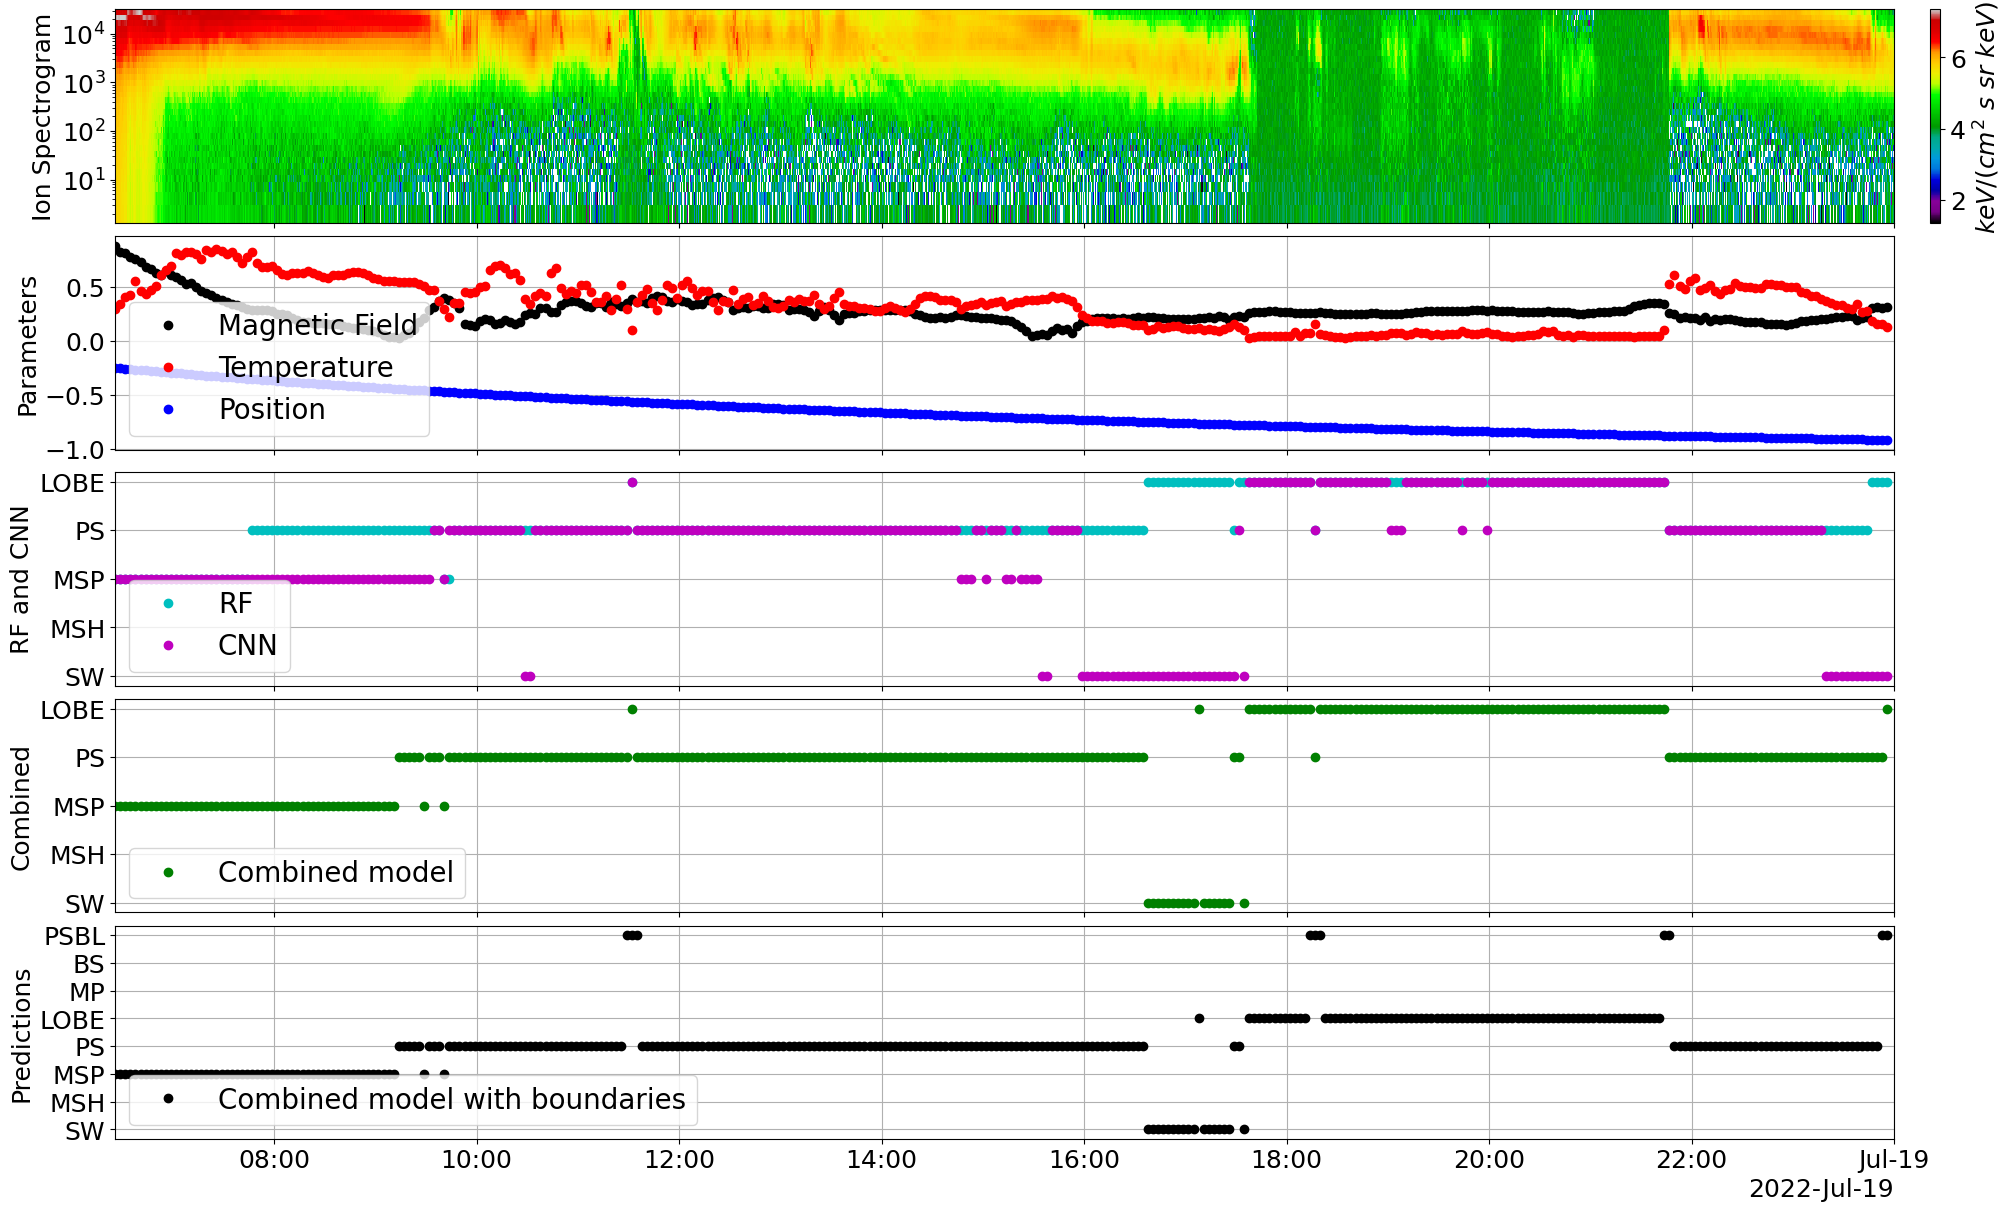

In [74]:
# import predict
# trange = ['2023-05-02/00:00:00', '2023-05-02/23:59:00']
# predict.predictions_cnn_rf(model, rf, trange)

# trange = ['2019-11-09/00:05:00', '2019-11-09/23:59:00']
# trange = ['2019-12-07/00:05:00', '2019-12-07/23:59:00']
# trange = ['2023-04-17/00:00:00', '2023-04-17/23:59:00']
# trange = ['2025-03-10/00:00:00', '2025-03-10/23:59:00']


## nightside use case
# trange = ['2019-07-13/00:00:00', '2019-07-13/23:59:00']
trange = ['2022-07-18/00:00:00', '2022-07-18/23:59:00']
# trange = ['2021-08-31/00:00:00', '2021-08-31/23:59:00']
# trange = ['2024-08-24/00:00:00','2024-08-24/23:59:00']


## flank use case
# trange = ['2015-09-15/00:08:00', '2015-09-15/20:00:00'] # flank
# trange = ['2015-09-19/00:07:00', '2015-09-19/20:00:00'] # flank

predictions_cnn_rf(cnn_model, rf, trange)